#### Author: Madhusudhanan Balasubramanian (MB), Ph.D., The University of Memphis
#### Final AP and AR statistics for Mask RCNN
MB, April 20, 2025

In [ ]:
#Libraries / modules
import os
import sys
import numpy as np

# Import Mask RCNN
ROOT_DIR = "./Mask_RCNN"
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
#
from keras.preprocessing.image import img_to_array
#

#Using pycocotools for AP and AR calculations as in centermask
import json
from pycocotools.coco import COCO
import pycocotools.mask as mask_util
import axon_coco as coco #copied samples/coco/coco.py as axon_coco.py
from axonlib.cocoeval import COCOeval
import pandas as pd
#
#import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

#Visualization
from axonlib.axon_visualizer_mrcnn import Visualizer, ColorMode

Using TensorFlow backend.


Utility functions

In [3]:
def format_predictions_to_coco(all_results, image_ids, category_ids):
    """
    Formats Mask R-CNN results for multiple images into COCO JSON format.

    Args:
        all_results: A list of results, where each result is the output of 
                     model.detect([image_array])[0] for a single image.
        image_ids: A list of COCO image IDs, corresponding to the order of 
                   images processed.
        category_ids: A list or dictionary mapping your model's class IDs to COCO 
                      category IDs.
                      For example: {1: 1, 2: 2, 3: 3, ...}

    Returns:
        A list of dictionaries, each representing a detection in COCO format.
    """

    coco_results = []
    for image_index, image_id in enumerate(image_ids):
        #print(f"image_id: {image_id}")
        results = all_results[image_index]
        for i in range(results['rois'].shape[0]):  # Iterate through detections
            y1, x1, y2, x2 = results['rois'][i]
            bbox = [x1, y1, x2 - x1, y2 - y1]  # COCO format: [x, y, width, height]

            class_id = int(results['class_ids'][i]) - 1
            #print(f"class_id: {class_id}")
            coco_cat_id = int(category_ids[class_id])  # Map to COCO cat ID

            coco_result = {
                "image_id": int(image_id),  # Ensure image_id is an integer
                "category_id": coco_cat_id,
                "bbox": [float(x) for x in bbox],  # Ensure bbox values are floats
                "score": float(results['scores'][i])
            }

            if 'masks' in results:
                mask = results['masks'][:, :, i]
                # RLE encoding of the mask (COCO format)
                rle = mask_util.encode(np.array(mask[:, :, np.newaxis], order='F'))[0]
                rle['counts'] = rle['counts'].decode('ascii')  # Necessary for JSON serialization
                coco_result["segmentation"] = rle

            coco_results.append(coco_result)
    return coco_results

def visualize_coco_image_and_anns(coco: COCO, img_id: int, image_dir: str):
    """
    Visualizes a COCO image with its bounding box annotations using Matplotlib.

    Args:
        coco: A pycocotools.coco.COCO object.
        img_id: The ID of the image to visualize.
        image_dir: The directory where the COCO images are stored.
    """

    try:
        # Load image information
        img_info = coco.loadImgs(ids=[img_id])[0]
        image_path = os.path.join(image_dir, img_info['file_name'])
        print(f"{img_info}\n{image_path}")

        # Load the image
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image not found at: {image_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Display the image
        plt.imshow(image)
        plt.axis('off')

        # Load annotations
        ann_ids = coco.getAnnIds(imgIds=[img_id])
        anns = coco.loadAnns(ids=ann_ids)

        # Draw bounding boxes and labels
        for ann in anns:
            bbox = ann['bbox']
            x, y, w, h = bbox
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)

            cat_id = ann['category_id']
            cat = coco.loadCats(ids=[cat_id])[0]
            #plt.text(x, y - 5, cat['name'], color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

        plt.show()

    except FileNotFoundError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [ ]:
class InferenceParams():
    def __init__(self, model_root_dir, model_subdir, model_weight_file,
                 data_root_dir, dataset_name,
                 mrcnn_lib_dir=None):
        
        debug_flag = 0

        # Root directory of the project
        if mrcnn_lib_dir is not None:
            self.mrcnn_lib_dir = "./Mask_RCNN"
        else:
            self.mrcnn_lib_dir = mrcnn_lib_dir

        #Model configuration
        self.inference_config = InferenceConfig()
        if debug_flag == 1:
            self.inference_config.display()

        #Model params
        self.model_root_dir = model_root_dir
        self.model_path = os.path.join(model_root_dir, model_subdir)
        self.model_weight_file = model_weight_file
        self.model_abs_file = os.path.join(self.model_path, self.model_weight_file)

        #Data params and initialization
        self.data_root_dir = data_root_dir
        self.dataset_name = dataset_name
        self.data_dir = os.path.join(self.data_root_dir, self.dataset_name)
        #
        self.axon_dataset = coco.CocoDataset()
        print(f"self.data_root_dir: {self.data_root_dir}")
        self.input_coco_obj = self.axon_dataset.load_coco(self.data_root_dir, self.dataset_name, return_coco=True)
        self.axon_dataset.prepare() # Must call before using the dataset

        #Evaluation / output directory
        self.eval_dir = os.path.join(self.model_path, 'Evaluations', dataset_name)
        os.makedirs(self.eval_dir, exist_ok=True)
        
        ft_json_file = f"{dataset_name}.json"
        self.gt_json_file = os.path.join(self.data_root_dir, self.dataset_name, ft_json_file)
        self.predictions_file = os.path.join(self.eval_dir, "coco_instances_results.json")


#Model configuration for inference
class InferenceConfig(coco.CocoConfig):
    #Dec 09, 2021 MB notes: Initially, no other configuration changes needed for training (recall / see that
    # configuration changes required for inferences such as setting # GPUs to 1, etc. See axon_coco.py for 
    # other possible configuration changes
    
    #General model parameters
    BACKBONE = 'resnet50' #default is resnet101
    USE_MINI_MASK=True
    MEAN_PIXEL = [123.7, 116.8, 103.9]
        
    #General training parameters
    #----------------
    IMAGES_PER_GPU = 1 #should be 1 for inference
    GPU_COUNT = 1
    BATCH_SIZE = IMAGES_PER_GPU * GPU_COUNT #BATCH_SIZE calculated only in config.py's constructor in line 216
    #
    STEPS_PER_EPOCH = 3 #Jan 07: reduced from 100 to 75; May 10, 2022: steps/epoch = #training images/batch size
    VALIDATION_STEPS = 3 #originally 5, previously set at 15
    #
    GRADIENT_CLIP_NORM = 10.0
    LEARNING_MOMENTUM = 0.9
    WEIGHT_DECAY=0.0001
    LOSS_WEIGHTS = { "rpn_class_loss": 1., "rpn_bbox_loss": 1., "mrcnn_class_loss": 1., "mrcnn_bbox_loss": 1., "mrcnn_mask_loss": 1. }

    #RPN parameters
    #---------------
    # Length of square anchor side in pixels
    #RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128) #Was used in V11 which generated the model e608
    #RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64) #Incorrectly set this in V11_Phase2 - that's why the model had issues
    # Ratios of anchors at each cell (width/height)
    # A value of 1 represents a square anchor, and 0.5 is a wide anchor
    #RPN_ANCHOR_RATIOS = [0.5, 1, 2]
    RPN_ANCHOR_RATIOS = [0.25, 0.5, 1, 2, 4]
    #References for increasing number of detections: https://github.com/matterport/Mask_RCNN/issues/1884#:~:text=What%20seems%20to%20have%20had%20the%20greatest%20impact%20for%20us%20were%20the%20training%20configs%3A
    RPN_TRAIN_ANCHORS_PER_IMAGE = 600 #default: 256; Number of anchors per image selected to train the RPN
    MAX_GT_INSTANCES = 600 #Number of GT instances per image kept to train the network
    
    #Proposal layer parameters (not trainable layer; just filtering)
    #-------------------------
    PRE_NMS_LIMIT = 6000 #default: ;Number of anchors with the best RPN score that are retained
    RPN_NMS_THRESHOLD = 0.9 #0.7 #default is 0.7; area overlap among candidate anchors before dropping the anchor with the lowest score; higher values increases the number of region proposals
    POST_NMS_ROIS_TRAINING = 1800 # >Training; ROIs kept after non-maximum supression in the proposal layer; default is 2000
    POST_NMS_ROIS_INFERENCE = 8000 # >Inference; ROIs kept after NMS in the proposal layer based on their RPN score
    
    #Detection target layer parameters (training only; not a trainable layer; just filtering)
    #Receives at most POST_NMS_ROIS_TRAINING number of anchors from the proposal layer
    #Anchors whose IoU > 0.5 over ground truth are selected (at most POST_NMS_ROIS_TRAINING)
    #---------------------------------
    TRAIN_ROIS_PER_IMAGE = 600 #default is 200; no. of ROIs randomly selected out of POST_NMS_ROIS_TRAINING
    ROI_POSITIVE_RATIO = 0.33 #default is 0.33; usually set as 1/#classes; i.e. 33% of TRAIN_ROIS_PER_IMAGE should be positive
       
    #Detection layer parameters (inference only; not trainable, just filtering)
    #Receives at most POST_NMS_ROIS_INFERENCE number of anchors from the proposal layer
    #MB: https://medium.com/@umdfirecoml/training-a-mask-r-cnn-model-using-the-nucleus-data-bcb5fdbc0181 
    #----------------------------
    DETECTION_MIN_CONFIDENCE = 0.7 #default: 0.7; AOIs with lower confidence than this are discarded
    DETECTION_NMS_THRESHOLD = 0.3 #reference: 0.3; AOIs those with higher overlapping areas are discarded based on their RPN score

    #Feature Pyramid Network (FPN)
    #Has a classifier and mask graph; identifies class and generates mask
    #---------------------------------
    DETECTION_MAX_INSTANCES = 600 # >Inference; maximum number of instances identified by Mask RCNN

Evaluate model using parameters in "inf_params" and generate an output jason file with the instances detected

In [5]:
def eval_model_json_outfile(inf_params):

    debug_flag = 0
    
    #Initialize
    input_coco_obj = inf_params.input_coco_obj
    axon_dataset = inf_params.axon_dataset

    #Create a Mask RCNN model in "inference" mode
    model = modellib.MaskRCNN(mode="inference", 
                              config=inf_params.inference_config, 
                              model_dir = inf_params.model_root_dir)

    #Load model file
    model.load_weights(inf_params.model_abs_file, by_name=True)

    image_ids = []
    all_results = []
    category_ids = input_coco_obj.getCatIds()
    #print(f"category_ids: {category_ids}")
    #print(f"image ids: {axon_dataset.image_ids}")
    #print(f"image ids: {input_coco_obj.getImgIds()}")
    all_image_ids = input_coco_obj.getImgIds()
    for image_ind, image_id in enumerate(all_image_ids):
        
        #MB, important: load_image_gt is scaling the image to 1024 x 1024 before feeding to detect().
        # But detect() has internal mechanisms to scale/mold and unscale/unmold.  This is done based on the 
        # size of the input image and the config parameters IMAGE_MIN_SIZE, IMAGE_MAX_SIZE.  With load_image_gt(),
        # and with IMAGE_MAX_SIZE = 1024, the output from detect() is not unmolded.  i.e. detections won't match
        # with the original gt geometry of the annotations - replacing with simple imread instead
        #
        #original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        #    modellib.load_image_gt(axon_dataset, inf_params.inference_config, image_ind, use_mini_mask=False)
        #MB, problem reading from axon_dataset.image_info, use coco obj instead
        #print(f"image_id:{image_id}; ind: {image_ind}; path:{axon_dataset.image_info[image_ind]['path']}")
        #original_image = cv2.imread(axon_dataset.image_info[image_ind]['path'])
        img_file_name = os.path.join(inf_params.data_dir, input_coco_obj.imgs[image_id]['file_name'])
        print(f"image_id:{image_id}; ind: {image_ind}; img_file_name: {img_file_name}")
        original_image = cv2.imread(img_file_name)
        
        #MB note: it appears mold_image normalizes the image (subtract dataset mean)
        #         img_to_array(image) is used in test_axon_model_v1.ipynb
        #         This needs to be verified:
        #           detect() molds all input images in a format for feeding to the network
        #           So, no need to mold before calling detect
        #           expand_dims adds a new axis to represent multiple images fed to the network for detection
        #           np.expand_dims(image, 0) is same as [image]--the latter is a list with single entry
        #scaled_image = modellib.mold_image(image, cfg)
        #image_array = np.expand_dims(scaled_image, 0)
        image_array = img_to_array(original_image)
        #print(f"image_array.shape: {image_array.shape}; dtype: {image_array.dtype}; max: {image_array.max()}; min: {image_array.min()}")
        #plt.imshow(image_array.astype(np.uint8))
        #plt.show()

        #Detect objects in the image
        result = model.detect([image_array])[0]

        boxes = result["rois"]
        masks = result["masks"]
        class_ids = result["class_ids"]
        class_names = axon_dataset.class_names
        scores = result["scores"]

        if debug_flag == 1:
            #
            visualize.display_instances(image_array, boxes, masks, class_ids, 
                            class_names, scores,
                            figsize=(8,8),
                            show_mask=True, show_bbox=False, colors=None)

        #Update results with the current image information / results
        image_ids.append(image_id)
        all_results.append(result)

    coco_results = format_predictions_to_coco(all_results, image_ids, category_ids)

    with open(inf_params.predictions_file, "w") as f:
        json.dump(coco_results, f, indent=4)

COCO Evaluation

In [6]:
def estimate_model_performance(precisions, recalls):
    """
    Estimates model performance (AP, AR) from precisions and recalls matrices.
    
    Args:
        precisions (np.ndarray): Precision values from COCOeval.
        recalls (np.ndarray): Recall values from COCOeval.
    
    Returns:
        dict: A dictionary containing AP50, AP50to95, AR50, and AR50to95 for overall and per-category.
    """

    model_perf_dict = {
        'AP@50': [np.mean(precisions[0, 0, :, 0, 2]), precisions[0, 0, 0, 0, 2], precisions[0, 0, 1, 0, 2]],
        'AP@50Area': [np.mean(precisions[0, 0, :, 1, 2]), np.mean(precisions[0, 0, :, 2, 2]), np.mean(precisions[0, 0, :, 3, 2])],
        "AP50": [np.mean(precisions[0, :, :, 0, 2]), np.mean(precisions[0, :, 0, 0, 2]), np.mean(precisions[0, :, 1, 0, 2])],
        "AP50Area": [np.mean(precisions[0, :, :, 1, 2]), np.mean(precisions[0, :, :, 2, 2]), np.mean(precisions[0, :, :, 3, 2])],
        "AP50To95": [np.mean(precisions[:, :, :, 0, 2]), np.mean(precisions[:, :, 0, 0, 2]), np.mean(precisions[:, :, 1, 0, 2])],
        "AP50To95Area": [np.mean(precisions[:, :, :, 1, 2]), np.mean(precisions[:, :, :, 2, 2]), np.mean(precisions[:, :, :, 3, 2])],
        "AR50": [np.mean(recalls[0, :, 0, 2]), np.mean(recalls[0, 0, 0, 2]), np.mean(recalls[0, 1, 0, 2])],
        "AR50Area": [np.mean(recalls[0, :, 1, 2]), np.mean(recalls[0, :, 2, 2]), np.mean(recalls[0, :, 3, 2])],
        "AR50To95": [np.mean(recalls[:, :, 0, 2]), np.mean(recalls[:, 0, 0, 2]), np.mean(recalls[:, 1, 0, 2])],
        "AR50To95Area": [np.mean(recalls[:, :, 1, 2]), np.mean(recalls[:, :, 2, 2]), np.mean(recalls[:, :, 3, 2])]
    }
    return model_perf_dict

def eval_model_on_dataset_name(inf_params, bbox_or_segm):
    
    #Initialize
    dataset_name = inf_params.dataset_name
    gt_json_file = inf_params.gt_json_file
    model_file = inf_params.model_weight_file
    all_results = []

    # Load predictions directly from the json file 
    predictions_save_path = inf_params.predictions_file
        
    # Check if the prediction file contains valid detections
    with open(predictions_save_path, 'r') as f:
        coco_results = json.load(f)
        #if not coco_results:  # Check if coco_results is empty
        if len(coco_results) == 0: # Check if coco_results is empty
            print(f"No valid detections found in {predictions_save_path}, skipping evaluation.")
            model_results = {
                "model_final": model_file.split('/')[-1],
                "AP@50": 0, #AP@50 for a single recall
                "AP@50Area-Small": 0,
                "AP@50Area-Medium": 0,
                "AP@50Area-Large": 0,
                "AP@50-Cat0": 0,
                "AP@50-Cat1": 0,
                "AP50": 0,   # Overall AP50
                "AP50Area-Small": 0,
                "AP50Area-Medium": 0,
                "AP50Area-Large": 0,
                "AP50-cat0": 0,
                "AP50-cat1": 0,
                "AP50To95": 0,
                "AP50To95Area-Small": 0,
                "AP50To95Area-Medium": 0,
                "AP50To95Area-Large": 0,
                "AP50To95-cat0": 0,
                "AP50To95-cat1": 0,
                "AR50": 0,   # Overall AR50
                "AR50Area-Small": 0,
                "AR50Area-Medium": 0,
                "AR50Area-Large": 0,
                "AR50-cat0": 0,
                "AR50-cat1": 0,
                "AR50To95": 0,
                "AR50To95Area-Small": 0,
                "AR50To95Area-Medium": 0,
                "AR50To95Area-Large": 0,
                "AR50To95-cat0": 0,
                "AR50To95-cat1": 0
            }
            all_results.append(model_results)

    # Use the COCO API to evaluate and calculate AR
    coco_gt = COCO(gt_json_file)  # Path to your ground truth annotations
    coco_dt = coco_gt.loadRes(predictions_save_path) 
    coco_eval = COCOeval(coco_gt, coco_dt, bbox_or_segm)
    #
    coco_eval.params.maxDets = [1, 10, 600]
    #coco_eval.params.areaRng = [[0 ** 2, 1e5 ** 2], [0 ** 2, 32 ** 2], [32 ** 2, 96 ** 2], [96 ** 2, 1e5 ** 2]]
    #coco.areaRngLbl = ['all', 'small', 'medium', 'large']
    coco_eval.params.areaRng = [[0, 1.1e6/16], [0, 1304/16], [1304/16, 2256/16], [2256/16, 1.1e6/16]]
    #
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    # Extract AR metrics
    precisions = coco_eval.eval['precision']
    recalls = coco_eval.eval['recall']
    model_perf_dict = estimate_model_performance(precisions, recalls)
    print(model_perf_dict)
    model_results = {
        "model_final": model_file.split('/')[-1],
        "AP@50": model_perf_dict["AP@50"][0],
        "AP@50Area-Small": model_perf_dict["AP@50Area"][0],
        "AP@50Area-Medium": model_perf_dict["AP@50Area"][1],
        "AP@50Area-Large": model_perf_dict["AP@50Area"][2],
        "AP@50-cat0": model_perf_dict["AP@50"][1],
        "AP@50-cat1": model_perf_dict["AP@50"][2],
        "AP50": model_perf_dict["AP50"][0],   # Overall AP50
        "AP50Area-Small": model_perf_dict["AP50Area"][0],
        "AP50Area-Medium": model_perf_dict["AP50Area"][1],
        "AP50Area-Large": model_perf_dict["AP50Area"][2],
        "AP50-cat0": model_perf_dict["AP50"][1],
        "AP50-cat1": model_perf_dict["AP50"][2],
        "AP50To95": model_perf_dict["AP50To95"][0],
        "AP50To95Area-Small": model_perf_dict["AP50To95Area"][0],
        "AP50To95Area-Medium": model_perf_dict["AP50To95Area"][1],
        "AP50To95Area-Large": model_perf_dict["AP50To95Area"][2],
        "AP50To95-cat0": model_perf_dict["AP50To95"][1],
        "AP50To95-cat1": model_perf_dict["AP50To95"][2],
        "AR50": model_perf_dict["AR50"][0],   # Overall AR50
        "AR50Area-Small": model_perf_dict["AR50Area"][0],
        "AR50Area-Medium": model_perf_dict["AR50Area"][1],
        "AR50Area-Large": model_perf_dict["AR50Area"][2],
        "AR50-cat0": model_perf_dict["AR50"][1],
        "AR50-cat1": model_perf_dict["AR50"][2],
        "AR50To95": model_perf_dict["AR50To95"][0],
        "AR50To95Area-Small": model_perf_dict["AR50To95Area"][0],
        "AR50To95Area-Medium": model_perf_dict["AR50To95Area"][1],
        "AR50To95Area-Large": model_perf_dict["AR50To95Area"][2],
        "AR50To95-cat0": model_perf_dict["AR50To95"][1],
        "AR50To95-cat1": model_perf_dict["AR50To95"][2]
    }

    all_results.append(model_results)

    # Create a DataFrame from the results
    results_df = pd.DataFrame(all_results)

    # Plotting the AP and AR metrics
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))  
    categories = ["Overall", "cat0", "cat1"]  

    for i, metric in enumerate(["AP@50", "AP50", "AP50To95"]):
        axes[0, i].plot(results_df["model_final"], results_df[metric], marker='o', linestyle='-', label=metric)
        for j, category in enumerate(categories[1:]): 
            axes[0, i].plot(results_df["model_final"], results_df[f'{metric}-{category}'], marker='x', linestyle='-', label=f'{metric}-{category}')
        axes[0, i].set_xlabel("Model Checkpoint")
        axes[0, i].set_ylabel("Average Precision")
        axes[0, i].set_title(f"{metric} for Different Model Checkpoints")
        axes[0, i].tick_params(axis='x', rotation=45)
        axes[0, i].legend()
        axes[0, i].grid(axis='y')

    for i, metric in enumerate(["AR50", "AR50To95"]):
        axes[1, i].plot(results_df["model_final"], results_df[metric], marker='o', linestyle='-', label=metric)
        for j, category in enumerate(categories[1:]):  # Start from index 1 for categories
            axes[1, i].plot(results_df["model_final"], results_df[f'{metric}-{category}'], marker='x', linestyle='-', label=f'{metric}-{category}')    
        axes[1, i].set_xlabel("Model Checkpoint")
        axes[1, i].set_ylabel("Average Recall")
        axes[1, i].set_title(f"{metric} for Different Model Checkpoints")
        axes[1, i].tick_params(axis='x', rotation=45)
        axes[1, i].legend()
        axes[1, i].grid(axis='y')

    fig.suptitle("Overall Performance Metrics")
    plt.tight_layout()
    plt.show()

    # Display the results in a table
    print(results_df.set_index("model_final").T)

Common parameters

In [ ]:
model_root_dir = "./logs/"
model_subdir = "coco20250418T0934"
model_weight_file = "mask_rcnn_coco_0263.h5"
#
# Data directory
data_root_dir = "./DataFiles/Phase3"

Phase3 Validation

self.data_root_dir: /home/madhu/Lab/Members/00_madhu/DataFiles/Phase3
loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
Re-starting from epoch 263
image_id:5167; ind: 0; img_file_name: /home/madhu/Lab/Members/00_madhu/DataFiles/Phase3/Phase3_Validation/2006---Rat-77E6772---p88-F_m10_06_A_D.tif
image_id:5168; ind: 1; img_file_name: /home/madhu/Lab/Members/00_madhu/DataFiles/Phase3/Phase3_Validation/2006---Rat-77E7654---p87-M--NEW_m10_11_D_A.tif
image_id:5169; ind: 2; img_file_name: /home/madhu/Lab/Members/00_madhu/DataFiles/Phase3/Phase3_Validation/2006---Rat-77E7654---p87-M--NEW_m16_07_B_C.tif
image_id:5170; ind: 3; img_file_name: /home/madhu/Lab/Members/00_madhu/DataFiles/Phase3/Phase3_Validation/2006---Rat-77E82F7---p92-M---NEW_m03_14_C_D.tif
image_id:5171; ind: 4; img_file_name: /home/madhu/Lab/Members/00_madhu/DataFiles/Phase3/Phase3_Validation/2006---Rat-77E82F7---p92-M---NEW_m04_11_D_A.tif
image_id:5172; ind: 5; img_file_name: /home/madhu/Lab/Memb

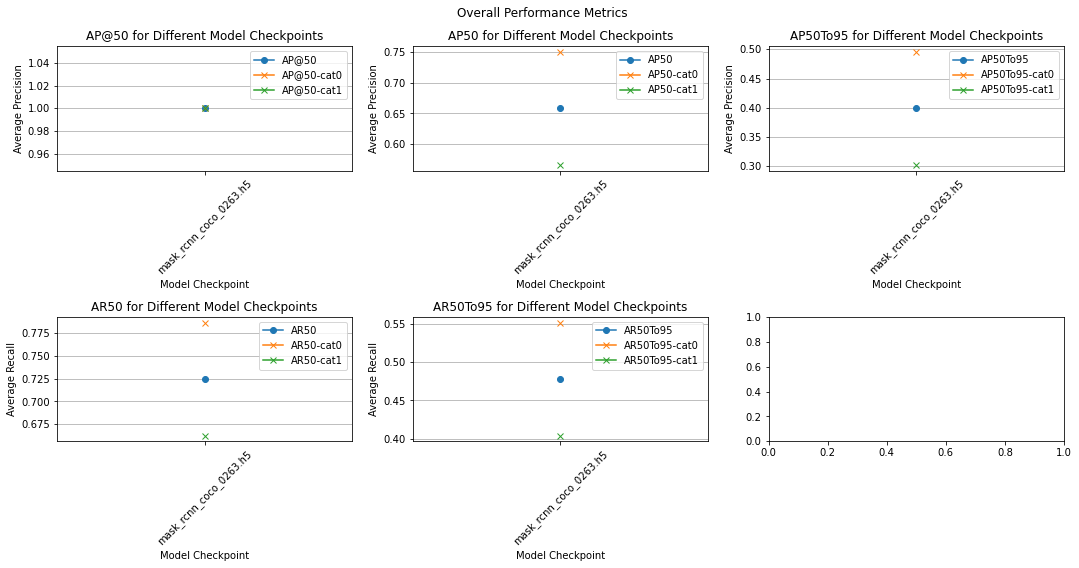

model_final          mask_rcnn_coco_0263.h5
AP@50                              1.000000
AP@50Area-Small                    1.000000
AP@50Area-Medium                   1.000000
AP@50Area-Large                    0.666667
AP@50-cat0                         1.000000
AP@50-cat1                         1.000000
AP50                               0.658310
AP50Area-Small                     0.508818
AP50Area-Medium                    0.557634
AP50Area-Large                     0.475165
AP50-cat0                          0.750637
AP50-cat1                          0.565982
AP50To95                           0.398926
AP50To95Area-Small                 0.271176
AP50To95Area-Medium                0.346289
AP50To95Area-Large                 0.324439
AP50To95-cat0                      0.495554
AP50To95-cat1                      0.302297
AR50                               0.724490
AR50Area-Small                     0.545100
AR50Area-Medium                    0.665445
AR50Area-Large                  

In [10]:
dataset_name = "Phase3_Validation"
bbox_or_segm = "segm"

inf_params = InferenceParams(model_root_dir, model_subdir, model_weight_file,
                             data_root_dir, dataset_name)

#Evaluate the model with the given dataset in dataset_name
eval_model_json_outfile(inf_params)

#Evaluate COCO results for the model predictions
eval_model_on_dataset_name(inf_params, bbox_or_segm)

Phase3 Testing

self.data_root_dir: /home/madhu/Lab/Members/00_madhu/DataFiles/Phase3
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Re-starting from epoch 263
image_id:5181; ind: 0; img_file_name: /home/madhu/Lab/Members/00_madhu/DataFiles/Phase3/Phase3_Testing/2006---Rat-77E6772---p88-F_m15_09_C_A.tif
image_id:5182; ind: 1; img_file_name: /home/madhu/Lab/Members/00_madhu/DataFiles/Phase3/Phase3_Testing/2006---Rat-77E6772---p88-F_m16_05_A_C.tif
image_id:5183; ind: 2; img_file_name: /home/madhu/Lab/Members/00_madhu/DataFiles/Phase3/Phase3_Testing/2006---Rat-77E7654---p87-M--NEW_m19_06_A_D.tif
image_id:5184; ind: 3; img_file_name: /home/madhu/Lab/Members/00_madhu/DataFiles/Phase3/Phase3_Testing/2006---Rat-77E7654---p87-M--NEW_m23_08_B_D.tif
image_id:5185; ind: 4; img_file_name: /home/madhu/Lab/Members/00_madhu/DataFiles/Phase3/Phase3_Testing/2006---Rat-77E7975---p86-F--NEW_m02_13_C_C.tif
image_id:5186; ind: 5; img_file_name: /home/madhu/Lab/Members/00_madhu/DataFiles

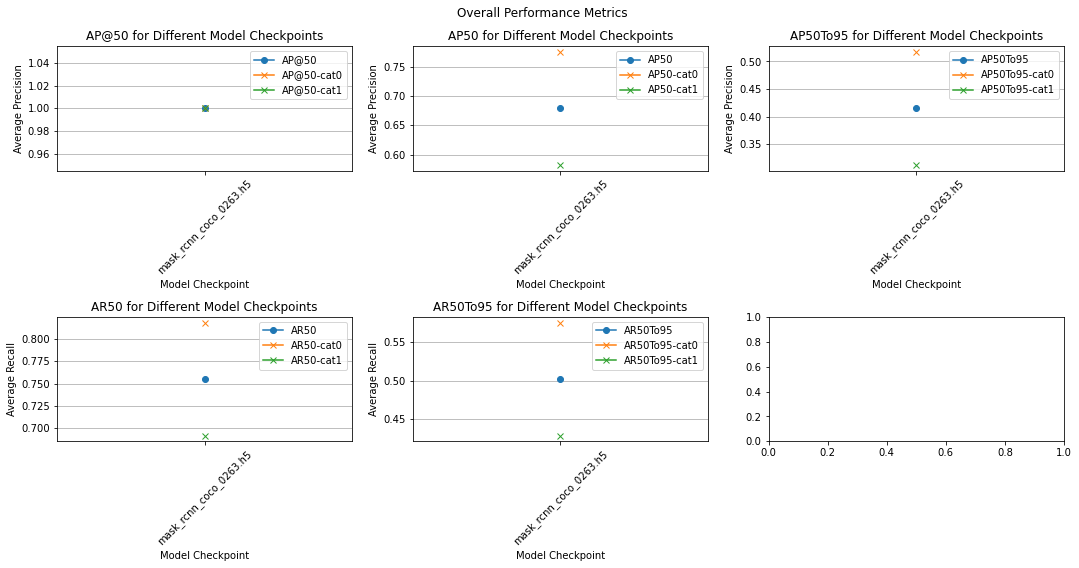

model_final          mask_rcnn_coco_0263.h5
AP@50                              1.000000
AP@50Area-Small                    1.000000
AP@50Area-Medium                   0.888889
AP@50Area-Large                    0.508197
AP@50-cat0                         1.000000
AP@50-cat1                         1.000000
AP50                               0.678671
AP50Area-Small                     0.560567
AP50Area-Medium                    0.559749
AP50Area-Large                     0.450809
AP50-cat0                          0.775082
AP50-cat1                          0.582261
AP50To95                           0.414821
AP50To95Area-Small                 0.308720
AP50To95Area-Medium                0.349497
AP50To95Area-Large                 0.309622
AP50To95-cat0                      0.517415
AP50To95-cat1                      0.312228
AR50                               0.755039
AR50Area-Small                     0.603224
AR50Area-Medium                    0.691439
AR50Area-Large                  

In [11]:
dataset_name = "Phase3_Testing"
bbox_or_segm = "segm"

inf_params = InferenceParams(model_root_dir, model_subdir, model_weight_file,
                             data_root_dir, dataset_name)

#Evaluate the model with the given dataset in dataset_name
eval_model_json_outfile(inf_params)

#Evaluate COCO results for the model predictions
eval_model_on_dataset_name(inf_params, bbox_or_segm)

Quigley Eval

self.data_root_dir: /home/madhu/Lab/Members/00_madhu/DataFiles/Phase3
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
Re-starting from epoch 263
image_id:5254; ind: 0; img_file_name: /home/madhu/Lab/Members/00_madhu/DataFiles/Phase3/Quigley_Eval/Ms6770ON01_1x1.tif
image_id:5255; ind: 1; img_file_name: /home/madhu/Lab/Members/00_madhu/DataFiles/Phase3/Quigley_Eval/Ms6770ON01_1x2.tif
image_id:5256; ind: 2; img_file_name: /home/madhu/Lab/Members/00_madhu/DataFiles/Phase3/Quigley_Eval/Ms6770ON01_2x1.tif
image_id:5257; ind: 3; img_file_name: /home/madhu/Lab/Members/00_madhu/DataFiles/Phase3/Quigley_Eval/Ms6770ON01_2x2.tif
image_id:5258; ind: 4; img_file_name: /home/madhu/Lab/Members/00_madhu/DataFiles/Phase3/Quigley_Eval/Ms6770ON02_1x1.tif
image_id:5259; ind: 5; img_file_name: /home/madhu/Lab/Members/00_madhu/DataFiles/Phase3/Quigley_Eval/Ms6770ON02_1x2.tif
image_id:5260; ind: 6; img_file_name: /home/madhu/Lab/Members/00_madhu/DataFiles/Phase3/Quigley_Eval

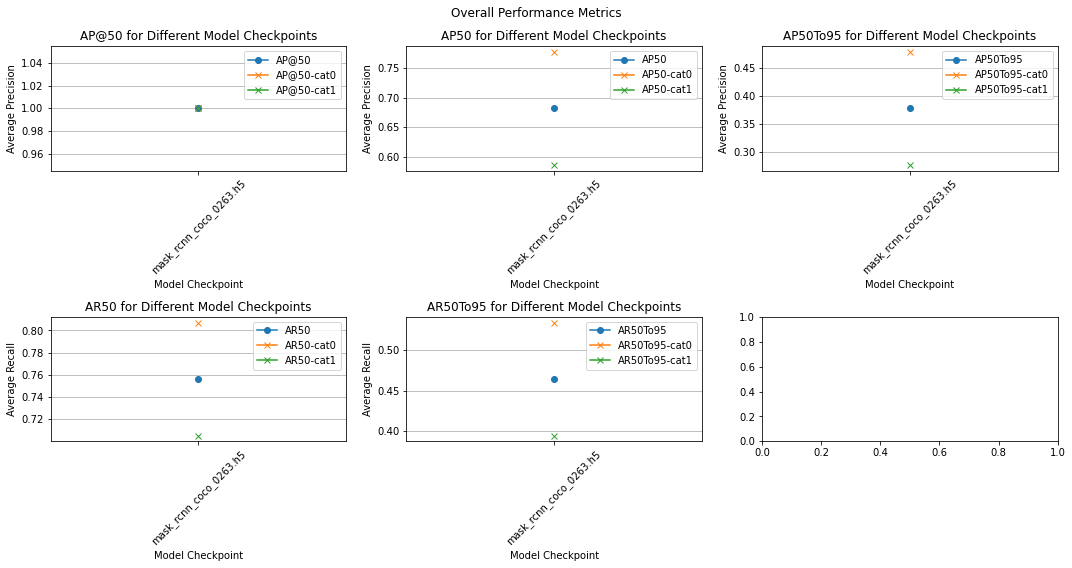

model_final          mask_rcnn_coco_0263.h5
AP@50                              1.000000
AP@50Area-Small                    1.000000
AP@50Area-Medium                   1.000000
AP@50Area-Large                    1.000000
AP@50-cat0                         1.000000
AP@50-cat1                         1.000000
AP50                               0.681664
AP50Area-Small                     0.507125
AP50Area-Medium                    0.613648
AP50Area-Large                     0.498439
AP50-cat0                          0.777106
AP50-cat1                          0.586221
AP50To95                           0.377491
AP50To95Area-Small                 0.228666
AP50To95Area-Medium                0.321828
AP50To95Area-Large                 0.303639
AP50To95-cat0                      0.478541
AP50To95-cat1                      0.276440
AR50                               0.756187
AR50Area-Small                     0.530651
AR50Area-Medium                    0.658630
AR50Area-Large                  

In [12]:
dataset_name = "Quigley_Eval"
bbox_or_segm = "segm"

inf_params = InferenceParams(model_root_dir, model_subdir, model_weight_file,
                             data_root_dir, dataset_name,
                             mrcnn_lib_dir=None)

#Evaluate the model with the given dataset in dataset_name
eval_model_json_outfile(inf_params)

#Evaluate COCO results for the model predictions
eval_model_on_dataset_name(inf_params, bbox_or_segm)